# Pembelajaran Mesin: Tugas Besar 2 (Data Exploration, and Preparation)

Kaenova Mahendra Auditama (1301190324)  
M Adi Ikfini (1301194160)  
IF-43-02  

  
Pada kodingan ini, kami mencoba untuk membuat sebuah model yang akan digunakan untuk membuat prediksi pada suatu data. Data yang diberikan merupakan data ketertarikan pelanggan untuk membeli kendaraan baru. Kami diminta untuk menggunakan metode supervised learning untuk melakukan prediksi tersebut. Kami akan mencoba melakukan prediksi menggunakan training data dan testing data dengan data yang imbalance.

# Pre-Requisite

## Import Library

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle
import random
import math
import sklearn
from sklearn.preprocessing import MinMaxScaler
from urllib.request import urlopen
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import imblearn
# Seeding for predictable output
tf.random.set_seed(1)
np.random.seed(1)

## Import Data

### Import Train

In [ ]:
df_raw_train = pd.read_csv("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/data/raw/kendaraan_train.csv")
df_raw_train.head()

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0


In [ ]:
len(df_raw_train)

285831

### Import Test

In [ ]:
df_raw_test = pd.read_csv("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/data/raw/kendaraan_test.csv")
df_raw_test.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,Wanita,49,1,8,0,1-2 Tahun,Pernah,46963,26,145,0
1,Pria,22,1,47,1,< 1 Tahun,Tidak,39624,152,241,0
2,Pria,24,1,28,1,< 1 Tahun,Tidak,110479,152,62,0
3,Pria,46,1,8,1,1-2 Tahun,Tidak,36266,124,34,0
4,Pria,35,1,23,0,1-2 Tahun,Pernah,26963,152,229,0


In [ ]:
len(df_raw_test)

47639

# Data Exploration

## Check Imbalance on RAW Data (Before PreProcessing)

In [ ]:
neg, pos = np.bincount(df_raw_train['Tertarik'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 285831
    Positive: 35006 (12.25% of total)



In [ ]:
neg, pos = np.bincount(df_raw_test['Tertarik'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 47639
    Positive: 5861 (12.30% of total)



## Check Null Data 

In [ ]:
# Apakah ada null data pada data train?
df_nan_raw_train = df_raw_train[df_raw_train.isnull().any(axis=1)]

In [ ]:
neg, pos = np.bincount(df_nan_raw_train['Tertarik'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 114763
    Positive: 14208 (12.38% of total)



In [ ]:
# Apakah ada null data pada data test?
df_nan_raw_test = df_raw_test[df_raw_test.isnull().any(axis=1)]
df_nan_raw_test

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik


The train data has a null data with a terget category ratio similiar with the RAW data, thus if we try to delete the null data, the ratio is slightly change and didnt break the data itself. Other than that, the test data, doesn't have null data.

## Duplicate Data

In [ ]:
temp_df = df_nan_raw_train.duplicated(keep=False)
df_nan_raw_train[temp_df]

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik


In [ ]:
temp_df = df_nan_raw_test.duplicated(keep=False)
df_nan_raw_test[temp_df]

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik


Tidak ada data yang terduplikat

## Checking Outlier using Box Plot
Checking outlier on Umur and Lama_Berlangganan

Text(0.5, 1.0, 'Lama Berlangganan')

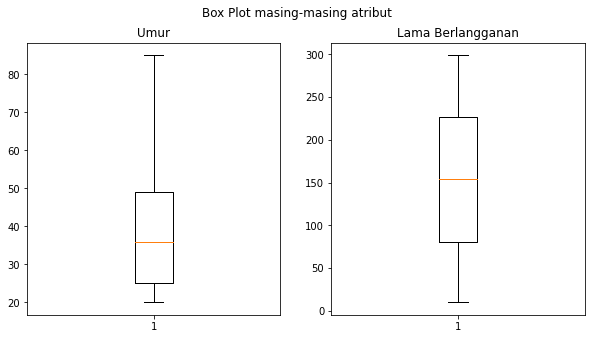

In [ ]:
fig, (g1, g2) = plt.subplots(1,2)
fig.suptitle("Box Plot masing-masing atribut")
fig.set_size_inches(10,5)
g1.boxplot(df_raw_train.dropna(how="any")["Umur"])
g1.set_title("Umur")
g2.boxplot(df_raw_train.dropna(how="any")["Lama_Berlangganan"])
g2.set_title("Lama Berlangganan")

Nice.. tidak ada outlier.

## Analyzing Weird Attribute
*An attribute that doesn't have any explanation or we just can't figure it out (lol)

![](https://www.uth.tmc.edu/uth_orgs/educ_dev/oser/FIG1_1.GIF)

In [ ]:
# Let's remove the NaN values in dataframe for better analyze 

df_train_analyze_all = df_raw_train.dropna(how="any") # If we remove any nan value in any columns

df_train_analyze_daerah = df_raw_train["Kode_Daerah"].dropna(how="any") # remove nan value in kode_daerah column
df_test_analyze_daerah = df_raw_test["Kode_Daerah"].dropna(how="any")

df_train_analyze_kanal = df_raw_train["Kanal_Penjualan"].dropna(how="any") # remove nan value in kanal_penjualan column
df_test_analyze_kanal = df_raw_test["Kanal_Penjualan"].dropna(how="any")

df_train_analyze_premi = df_raw_train["Premi"].dropna(how="any")

In [ ]:
df_train_analyze_all.columns

Index(['id', 'Jenis_Kelamin', 'Umur', 'SIM', 'Kode_Daerah', 'Sudah_Asuransi',
       'Umur_Kendaraan', 'Kendaraan_Rusak', 'Premi', 'Kanal_Penjualan',
       'Lama_Berlangganan', 'Tertarik'],
      dtype='object')

In [ ]:
categorical_cols = ['Jenis_Kelamin', 'SIM', 'Sudah_Asuransi', 'Kendaraan_Rusak', 'Tertarik']

Data yang di pertanyakan


### Kode Daerah
Dari namanya, bisa kita sebutkan bahwa ini sebuah qualitative (nominal) atribut(?).  
let's try to treat it as it is


Hasil hystogram 



(array([ 8766., 22877., 15401.,  5911.,  5615., 61164., 12612., 14237.,
        13283., 11202.]),
 array([ 0. ,  5.2, 10.4, 15.6, 20.8, 26. , 31.2, 36.4, 41.6, 46.8, 52. ]),
 <a list of 10 Patch objects>)

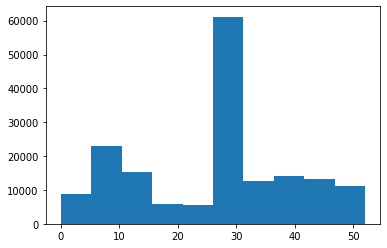

In [ ]:
plt.hist(df_train_analyze_all["Kode_Daerah"])

(array([ 2412.,  6385.,  4379.,  1666.,  1558., 17125.,  3500.,  3945.,
         3632.,  3037.]),
 array([ 0. ,  5.2, 10.4, 15.6, 20.8, 26. , 31.2, 36.4, 41.6, 46.8, 52. ]),
 <a list of 10 Patch objects>)

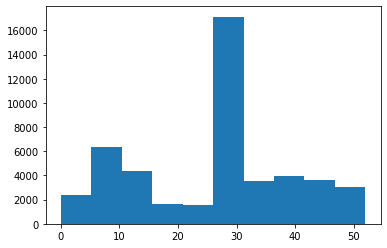

In [ ]:
plt.hist(df_test_analyze_daerah)

In [ ]:
np.sort(df_train_analyze_daerah.unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52.])

In [ ]:
np.sort(df_train_analyze_all["Kode_Daerah"].unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52.])

Bisa diambil kesimpulan bahwa kita bisa menganggap atribut ini sebagai atribut Categorical, selain itu kita bisa melakukan One Hot Encoding terhadap atribut ini, dikarenakan distribusi dari atribnut ini serupa dan bisa di intuisikan bahwa setiap nilai memiliki "beratnya tersendiri." Hal ini kami bisa anggap aman karena pada data testing pun memiliki distribusi yang serupa walaupun pada setiap kolom jika ada nilai null dan dihapus.

### Premi
First of all, what is Premi even means?  
In KBBI (https://kbbi.kemdikbud.go.id/entri/premi) we can conclude that premi is quantitative attribute(?)  
1. n hadiah (uang dan sebagainya) yang diberikan sebagai perangsang untuk meningkatkan prestasi kerja
2. n hadiah (dalam undian, perlombaan, pembelian)
3. n jumlah uang yang harus dibayarkan pada waktu tertentu kepada asuransi sosial: -- asuransi

  
With this, let's try to treat it as quantitative attribute

In [ ]:
# Let's see if it's a float data or numerical data
np.unique(df_train_analyze_premi.unique() % 1)

array([0.])

Setelah dilihat, setiap nilai jika di modulus kan dengan nilai 1, semua hasil elemennya ialah 0. Sehingga bisa disimpulkan ini merupakan data numerical non floating (integer).

In [ ]:
# Let's see the correlation between the any other variables
df_train_analyze_all.corr()["Premi"]

id                   0.002145
Umur                 0.063838
SIM                 -0.012864
Kode_Daerah         -0.012462
Sudah_Asuransi       0.003988
Premi                1.000000
Kanal_Penjualan     -0.112297
Lama_Berlangganan   -0.001260
Tertarik             0.021890
Name: Premi, dtype: float64

In [ ]:
# plt.scatter(df_train_analyze_all["Tertarik"], df_train_analyze_all["Premi"] )

Feels like it doesn't have any correlation with any other quantitative attribute

{'boxes': [<matplotlib.lines.Line2D at 0x7f62ed31dd50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f62ed2a4e50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f62ed2abe90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f62ed2ab950>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f62ed2a43d0>,
  <matplotlib.lines.Line2D at 0x7f62ed2a4910>]}

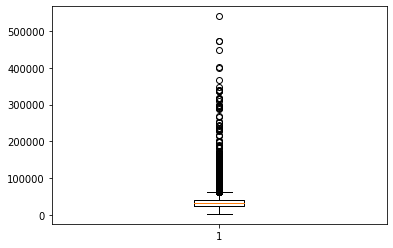

In [ ]:
# Let's see how the premi looks like
plt.boxplot(df_train_analyze_all["Premi"])

In [ ]:
df_train_analyze_premi.describe()

count    271262.000000
mean      30536.683472
std       17155.000770
min        2630.000000
25%       24398.000000
50%       31646.000000
75%       39377.750000
max      540165.000000
Name: Premi, dtype: float64

In [ ]:
# Let's see if total data if we remove the outlier using inter-quartile range method
print("Total data:", len(df_train_analyze_all))
df_train_analyze_all_premi = df_train_analyze_all["Premi"]
print("Not Outliers data:", len(df_train_analyze_all_premi[(df_train_analyze_all_premi < df_train_analyze_all_premi.describe().loc["75%"]) \
                           & (df_train_analyze_all_premi > df_train_analyze_all_premi.describe().loc["25%"])]))

Total data: 171068
Not Outliers data: 85534


Wew berkurang 50%.  
Mungkin biar aman, kita tidak perlu memasukkan Premi sebagai fitur model.  
Mengapa?
1. Data tidak bisa dianalisa dengan baik
2. Nilai korelasi yang rendah dengan atribut-atribute lain.
3. Ketika melakukan handling outlier terlalu mengurangi jumlah data

FIX PREMI TIDAK USAH JADI FITUR - TDT Kaenova & Adi

### Kanal Penjualan
(synm.) Salur penjualan(?)  
  
Kalau dari kata-katanya tidak mungkin ini nilai quantitative, yang sangat memungkinkan ini merupakan qualitative dalam bentuk numerical dan tidak bersifat ordinal. Let's analyze it

In [ ]:
# Let's see if it's a float data or numerical data
np.unique(df_train_analyze_kanal.unique() % 1)

array([0.])

Okay.. it's a numerical non floating number. This strengthen the theory that it's a qualitative attribute

In [ ]:
train_kanal = np.sort(df_train_analyze_kanal.astype('int').unique())
test_kanal = np.sort(df_test_analyze_kanal.unique())
all_kanal = set(train_kanal.tolist()+ test_kanal.tolist())

In [ ]:
not_in_train = []
not_in_test = []
for kanal in all_kanal:
    if kanal not in train_kanal:
        not_in_train.append(kanal)
    if kanal not in test_kanal:
        not_in_test.append(kanal)

print(not_in_train)
print(not_in_test)
len(not_in_test)

[]
[2, 6, 17, 27, 28, 50, 57, 69, 71, 74, 75, 82, 84, 100, 101, 110, 117, 123, 134, 137, 144]


21

Pada data testing, ada beberapa kode kanal yang tidak ada. Ini harus diperhatikan jika ingin melakukan one hot encoding, artinya kita harus menambahka kolom-kolom kanal tersebut agar memiliki bentuk data yang sama

In [ ]:
df_raw_train.iloc[151077]

id                      151078
Jenis_Kelamin             Pria
Umur                        43
SIM                          1
Kode_Daerah                NaN
Sudah_Asuransi               0
Umur_Kendaraan       1-2 Tahun
Kendaraan_Rusak         Pernah
Premi                     2630
Kanal_Penjualan             33
Lama_Berlangganan          235
Tertarik                     0
Name: 151077, dtype: object

Ada 1 dan bakal ilang sama drop NaN

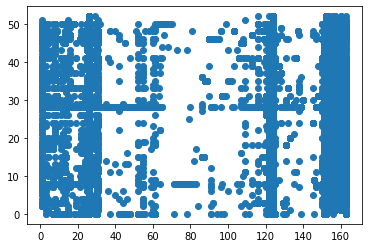

In [ ]:
plt.scatter(df_train_analyze_all["Kanal_Penjualan"], df_train_analyze_all["Kode_Daerah"])

Ambil contoh 1 sample, Kanal Penjualan "160" ada pada semua daerah. Artinya Kanal Penjualan tidak bisa dihubungkan dengan daerahnya. Sehingga kanal penjualan tidak terpaku pada daerahnya maisng-masing.  

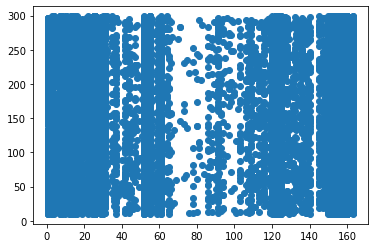

In [ ]:
plt.scatter(df_train_analyze_all["Kanal_Penjualan"], df_train_analyze_all["Lama_Berlangganan"])

Disini kami bisa menyimpulkan bahwa ini merupakan atribut ini merupakan variable qualitative non ordinal.
1. Tidak ada nilai koma, nilai koma sangat jarang dipakai pada nilai qualitative ataupun atribut kategorikal.
2. Ada beberapa nilai yang tidak ada dalam range nilai tersebut, diantaranya [5, 41, 43, 72, 77, 85, 141, 142, 143, 149, 161, 162,] Hal ini sangat wajar dalam atribut kategorikal yang belum tentu angka numerik harus terisi semua dalam range nya.

## So Far...
Atribut yang digunakan:
1. Categorical: ['Jenis_Kelamin', 'SIM', 'Sudah_Asuransi', 'Umur_Kendaraan', 'Kendaraan_Rusak', 'Kanal_Penjualan']
2. Numerical:  ['Umur', 'Lama_Berlangganan']

In [ ]:
df_train_drop = df_train_analyze_all.drop(axis=1, columns=["id", "Premi"])
df_train_target = df_train_analyze_all["Tertarik"]

In [ ]:
for cols in  ['Jenis_Kelamin', 'SIM', 'Sudah_Asuransi', 'Umur_Kendaraan', 'Kendaraan_Rusak', 'Kanal_Penjualan']:
    print(cols, df_train_drop[cols].unique())

Jenis_Kelamin ['Wanita' 'Pria']
SIM [1. 0.]
Sudah_Asuransi [1. 0.]
Umur_Kendaraan ['< 1 Tahun' '> 2 Tahun' '1-2 Tahun']
Kendaraan_Rusak ['Tidak' 'Pernah']
Kanal_Penjualan [152.  29. 124. 160. 145.  31.  26. 156. 122.  25.  11. 157.  30.   7.
 154.  23.  14.  16. 151.   4.  52. 155.  24.  22. 163. 120.   8. 125.
  12.   3.  94. 153. 131.  60.  47.  55.  10.  13. 150.  15.  18. 158.
  37.  19.   1. 129. 147.  56.  61. 136.   9. 119. 138. 111.  35. 135.
  65.  42.  21. 140.  64. 132.  48.  59. 139.  54. 108.  36.  44.  86.
 148.  46.  95. 109. 113. 137.  75.  97. 123. 116. 103. 126. 130.  66.
 128.  91.  78. 133. 159.  68.  63.  53. 121.  32. 127.  57.  93. 134.
 114.  92.  87. 118. 106. 117. 110. 107.  88.  38.  76.  90.  20.  51.
  96. 146.  83.  58.  84.  50.  98.  79.  89.  73.  80.  45.  28.  17.
  49. 105.  40.  62.   2.  81. 100.  69.  71.  34.  67.  82. 102.  99.
 101.  70. 115.  74.  39.]


In [ ]:
map_categorical = {
    "Jenis_Kelamin": {
        "Wanita" : 0,
        "Pria" : 1
    },
    "Kendaraan_Rusak" : {
        "Tidak" : 0,
        "Pernah" : 1
    }, 
    "Umur_Kendaraan" : {
        '< 1 Tahun' : 0,
        '1-2 Tahun' : 1,
        '> 2 Tahun' : 2
    }
}
df_train_mapped = df_train_drop.replace(map_categorical)
df_train_mapped["Kode_Daerah"] = df_train_mapped["Kode_Daerah"].astype(int) 
df_train_mapped["Umur"] = df_train_mapped["Umur"].astype(int) 
df_train_mapped["SIM"] = df_train_mapped["SIM"].astype(int) 
df_train_mapped["Kanal_Penjualan"] = df_train_mapped["Kanal_Penjualan"].astype(int) 
df_train_mapped["Sudah_Asuransi"] = df_train_mapped["Sudah_Asuransi"].astype(int) 
df_train_mapped

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0,30,1,33,1,0,0,152,97.0,0
1,1,48,1,39,0,2,1,29,158.0,0
3,0,58,1,48,0,1,0,124,63.0,0
5,1,21,1,35,1,0,0,152,171.0,0
8,0,20,1,8,1,0,0,160,31.0,0
...,...,...,...,...,...,...,...,...,...,...
285826,0,23,1,4,1,0,0,152,217.0,0
285827,0,21,1,46,1,0,0,152,50.0,0
285828,0,23,1,50,1,0,0,152,226.0,0
285829,1,68,1,7,1,1,0,124,270.0,0


### Correlation Numerical - Numerical
Menggunakan Pearson

In [ ]:
df_numerical = df_train_mapped[["Umur", "Lama_Berlangganan"]]
df_numerical.corr()

,Umur,Lama_Berlangganan
Umur,1.000000,-0.001032
Lama_Berlangganan,-0.001032,1.000000


Hasil korelasi dari data antar numerical

### Correlation Categorical - Categorical
Menggunakan Cramer's V
https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

In [ ]:
# https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix

categorical = ['Jenis_Kelamin', 'SIM', 'Kode_Daerah', 'Sudah_Asuransi', 'Umur_Kendaraan', 'Kendaraan_Rusak', 'Kanal_Penjualan']
df_categorical = df_train_mapped[categorical]

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

rows= []

for var1 in df_categorical:
  col = []
  for var2 in df_categorical :
    cramers =cramers_V(df_categorical[var1], df_categorical[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df_cramer = pd.DataFrame(cramers_results, columns = df_categorical.columns, index =df_categorical.columns)
df_cramer

,Jenis_Kelamin,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Kanal_Penjualan
Jenis_Kelamin,1.00,0.0,0.01,0.01,0.03,0.01,0.04
SIM,0.00,1.0,0.00,0.00,0.00,0.00,0.00
Kode_Daerah,0.01,0.0,1.00,0.06,0.09,0.05,0.02
Sudah_Asuransi,0.01,0.0,0.06,1.00,0.15,0.68,0.20
Umur_Kendaraan,0.03,0.0,0.09,0.15,1.00,0.16,0.39
Kendaraan_Rusak,0.01,0.0,0.05,0.68,0.16,1.00,0.21
Kanal_Penjualan,0.04,0.0,0.02,0.20,0.39,0.21,1.00


**Hasil korelasi terbesar pada sudah asuransi dan kendaraan rusak**.

# Data Preprocessing

Berdasarkan eksplorasi data yang kita temukan kami menyimpulkan beberapa poin:
1. Atribut yang tidak dijadikan fitur dalam model kami: [id, Premi, Tertarik]
2. Duplikat Data, Null Data  
3. Melakukan MinMaxScaler pada fitur numerical: ['Umur', 'Lama_Berlangganan']  
4. Oversampling menggunakan SMOTE 
5. Melakukan One Hot Encoding pada fitur categorical: ['Jenis_Kelamin', 'SIM', 'Sudah_Asuransi', 'Umur_Kendaraan', 'Kendaraan_Rusak', 'Kanal_Penjualan']. Perlu diperhatikan bahwa bentuk data kanal_penjualan tidak sama, harus membuat kolom kanal_penjualan dalam data test yang sama



In [ ]:
df_preprocess_train = df_raw_train.copy()
df_preprocess_test = df_raw_test.copy()

In [ ]:
df_preprocess_train.sample(5)

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
171267,171268,Pria,55.0,1.0,8.0,1.0,1-2 Tahun,Tidak,43507.0,124.0,287.0,0
239246,239247,Pria,46.0,1.0,28.0,0.0,1-2 Tahun,Pernah,33455.0,26.0,69.0,0
174596,174597,Pria,41.0,1.0,28.0,0.0,1-2 Tahun,Pernah,42689.0,124.0,170.0,0
115807,115808,Pria,NaN,NaN,31.0,0.0,1-2 Tahun,Pernah,2630.0,26.0,226.0,0
19169,19170,Wanita,23.0,1.0,23.0,NaN,< 1 Tahun,Tidak,25627.0,152.0,71.0,0


In [ ]:
df_preprocess_test.sample(5)

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
17204,Wanita,49,1,15,0,1-2 Tahun,Pernah,29414,14,28,0
45554,Pria,22,1,8,0,< 1 Tahun,Tidak,27806,152,184,0
41645,Pria,23,1,8,1,< 1 Tahun,Tidak,38465,152,76,0
13658,Wanita,68,1,2,0,< 1 Tahun,Tidak,2630,1,281,0
31298,Wanita,25,1,8,1,< 1 Tahun,Tidak,37381,152,133,0


## Filter Fitur yang Digunakan 

In [ ]:
df_preprocess_train_filter = df_preprocess_train.drop(axis=1, columns=["id", "Premi"])
df_preprocess_test_filter = df_preprocess_test.drop(axis=1 ,  columns=("Premi"))

## Drop Duplicate and Drop Nan

In [ ]:
df_preprocess_train_filter_change_drop = df_preprocess_train_filter.dropna()
df_preprocess_test_filter_change_drop = df_preprocess_test_filter.dropna()

## Merubah Tipe Data, Merubah String menjadi Number Code

In [ ]:
map_categorical = {
    "Jenis_Kelamin": {
        "Wanita" : 0,
        "Pria" : 1
    },
    "Kendaraan_Rusak" : {
        "Tidak" : 0,
        "Pernah" : 1
    }, 
    "Umur_Kendaraan" : {
        '< 1 Tahun' : 0,
        '1-2 Tahun' : 1,
        '> 2 Tahun' : 2
    }
}

df_preprocess_train_filter_change_drop[["Umur","Kode_Daerah", "SIM", "Sudah_Asuransi", "Kanal_Penjualan", "Lama_Berlangganan"]] = df_preprocess_train_filter_change_drop[["Umur", "Kode_Daerah", "SIM", "Sudah_Asuransi", "Kanal_Penjualan", "Lama_Berlangganan"]].astype('int')
df_preprocess_test_filter_change_drop[["Umur","Kode_Daerah", "SIM", "Sudah_Asuransi", "Kanal_Penjualan", "Lama_Berlangganan"]] = df_preprocess_test_filter_change_drop[["Umur", "Kode_Daerah", "SIM", "Sudah_Asuransi", "Kanal_Penjualan", "Lama_Berlangganan"]].astype('int')
df_preprocess_train_filter_change_drop.replace(map_categorical, inplace=True)
df_preprocess_test_filter_change_drop.replace(map_categorical, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
# Before
print("Train", len(df_preprocess_train_filter))
print("Test", len(df_preprocess_test_filter))

Train 285831
Test 47639


In [ ]:
# After
print("Train", len(df_preprocess_train_filter_change_drop))
print("Test", len(df_preprocess_test_filter_change_drop))

Train 180306
Test 47639


## Min Max Scaling on Numerical

In [ ]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(df_preprocess_train_filter_change_drop[["Umur", "Lama_Berlangganan"]])
min_max_scaler.fit(df_preprocess_test_filter_change_drop[["Umur", "Lama_Berlangganan"]])

df_preprocess_train_scaling = df_preprocess_train_filter_change_drop.copy()
df_preprocess_test_scaling = df_preprocess_test_filter_change_drop.copy()
df_preprocess_train_scaling[["Umur", "Lama_Berlangganan"]] = min_max_scaler.transform(df_preprocess_train_filter_change_drop[["Umur", "Lama_Berlangganan"]])
df_preprocess_test_scaling[["Umur", "Lama_Berlangganan"]] = min_max_scaler.transform(df_preprocess_test_filter_change_drop[["Umur", "Lama_Berlangganan"]])

## Oversampling Train Data

In [ ]:
sampler = imblearn.over_sampling.SMOTE(sampling_strategy=0.8 ,random_state=1)
Xres, yres = sampler.fit_resample(df_preprocess_train_scaling.drop(axis=1, columns=["Tertarik"]), df_preprocess_train_scaling.filter(axis=1, items=["Tertarik"]))
Xres["Tertarik"] = yres
df_preprocess_train_scaling = Xres

In [ ]:
neg, pos = np.bincount(Xres['Tertarik'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 285035
    Positive: 126682 (44.44% of total)



## One Hot Encoding on Categorical Attribute

In [ ]:
# Change Categorical with float datatype to string
df_preprocess_train_scaling[["SIM", "Kendaraan_Rusak", "Kode_Daerah", "Sudah_Asuransi", "Kanal_Penjualan", "Tertarik"]] = df_preprocess_train_scaling[["SIM", "Kendaraan_Rusak", "Kode_Daerah", "Sudah_Asuransi", "Kanal_Penjualan", "Tertarik"]].astype("object")
df_preprocess_test_scaling[["SIM", "Kendaraan_Rusak", "Kode_Daerah", "Sudah_Asuransi", "Kanal_Penjualan", "Tertarik"]] = df_preprocess_test_scaling[["SIM", "Kendaraan_Rusak","Kode_Daerah", "Sudah_Asuransi", "Kanal_Penjualan", "Tertarik"]].astype("object")

In [ ]:
df_onehot_train = pd.get_dummies(df_preprocess_train_scaling)
df_onehot_test = pd.get_dummies(df_preprocess_test_scaling)

In [ ]:
## ----------
## Menambahkan kolom yang tidak ada pada train ataupun test ketika dilakukan one Hot Encoding agar jumlah kolom menjadi sama
## ----------

a = np.sort(df_preprocess_train_scaling["Kanal_Penjualan"].unique()).tolist()
b = np.sort(df_preprocess_test_scaling["Kanal_Penjualan"].unique()).tolist()
a_before_preprocessing = np.sort(np.unique(df_preprocess_test["Kanal_Penjualan"].to_numpy())).tolist()
b_before_preprocessing = np.sort(np.unique(df_preprocess_train[(df_preprocess_train["Kanal_Penjualan"].isnull() == False)]["Kanal_Penjualan"].astype('int').to_numpy())).tolist()

not_in_a = []
not_in_b = []
for kanal in set(a+b+a_before_preprocessing+b_before_preprocessing):
    if kanal not in a:
        not_in_a.append(kanal)
    if kanal not in b:
        not_in_b.append(kanal)

if (not_in_a or not_in_b):
    print("Warning: Ada Kolom yang tidak tersedia di training atau testing data untuk dilakukan one hot encoding.")
    print("         Akan dilakukan pengisian kolom agar bentuk menjadi sama.")
    print(not_in_a)
    print(not_in_b)
    print("Jumlah yang tidak ada pada train:", len(not_in_a))
    print("Jumlah yang tidak ada pada test:",len(not_in_b))

# Filling for One Hot Encoding Train
fill_one_hot_train = []
for i in not_in_a:
    temp = []
    nama = f"Kanal_Penjualan_{i}"
    cols = np.zeros(len(df_preprocess_train_scaling))
    temp.append(nama)
    temp.append(cols)
    fill_one_hot_train.append(temp)

# Filling for One Hot Encoding Test
fill_one_hot_test = []
for i in not_in_b:
    temp = []
    nama = f"Kanal_Penjualan_{i}"
    cols = np.zeros(len(df_preprocess_test_scaling))
    temp.append(nama)
    temp.append(cols)
    fill_one_hot_test.append(temp)

# Filling one hot encoding
for new_cols in fill_one_hot_train:
    df_onehot_train[new_cols[0]] = new_cols[1]

for new_cols in fill_one_hot_test:
    df_onehot_test[new_cols[0]] = new_cols[1]

df_onehot_train = df_onehot_train.reindex(columns=sorted(df_onehot_train.columns))
cols_at_end = ['Tertarik_0', 'Tertarik_1']
df_onehot_train = df_onehot_train[[c for c in df_onehot_train if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df_onehot_train]]

df_onehot_test = df_onehot_test.reindex(columns=sorted(df_onehot_test.columns))
cols_at_end = ['Tertarik_0', 'Tertarik_1']
df_onehot_test = df_onehot_test[[c for c in df_onehot_test if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df_onehot_test]]

         Akan dilakukan pengisian kolom agar bentuk menjadi sama.
[144]
[2, 5, 6, 17, 27, 28, 41, 50, 57, 69, 71, 74, 75, 82, 84, 85, 100, 101, 110, 117, 123, 134, 137, 144, 149]
Jumlah yang tidak ada pada train: 1
Jumlah yang tidak ada pada test: 25


### Check Hasil One Hot

In [ ]:
# Cek bentuk
print(df_onehot_train.shape)
print(df_onehot_test.shape)

(285035, 220)
(47639, 220)


In [ ]:
# Cari kolom yang gaada di data train atau test
one_hot_not_appear_train_test = []
for i in df_onehot_train.columns:
    if i not in df_onehot_test.columns:
        print(i)
        one_hot_not_appear_train_test.append(i)

## Ambil Best Features (Kendaraan Rusak dan Sudah Asuransi) Untuk Percobaan Data Training

In [ ]:
df_preprocess_best_train = df_preprocess_train_scaling[["Kendaraan_Rusak", "Sudah_Asuransi", "Tertarik"]].copy()
df_preprocess_best_test = df_preprocess_test_scaling[["Kendaraan_Rusak", "Sudah_Asuransi", "Tertarik"]].copy()

In [ ]:
# One Hot Encoding
df_oneshot_best_train = pd.get_dummies(df_preprocess_best_train)
df_oneshot_best_test = pd.get_dummies(df_preprocess_best_test)

# Data Preparation

## Splitting Data Training for Model and Preparing Data Testing
Kita akan menggunakan teknik K-Fold yang stratified. Dengan K-Fold, kita dapat melihat Performansi Model secara keseluruhan data training. Ditambah dengan metode stratified, kita bisa mendapatkan ratio data yang serupa pada setiap foldnya
  
Kami akan mealukan K-Fold hanya pada data train yang diberikan
  
Kami menyiapkan beberapa bentuk data yang akan dicoba.

In [ ]:
training_testing_data = {}

### Best Feature (Ordinal Encoded on Target)

In [ ]:
train_best = df_oneshot_best_train.copy()
train_best.reset_index(drop=True, inplace=True)

X = train_best.drop(axis=1, columns=["Tertarik_0", "Tertarik_1"]).to_numpy()
y = np.argmax(train_best[["Tertarik_0", "Tertarik_1"]].to_numpy(), axis=1)
# Need to revert it back to ordinal coding, and in the k fold, we need to one hot it again

test_best = df_oneshot_best_test.copy()
test_best.reset_index(drop=True, inplace=True)

training_data_fold = {}
training_data_fold["column_in_order"] = train_best.columns

X_test = test_best.drop(axis=1, columns=["Tertarik_0", "Tertarik_1"]).to_numpy()
y_test = np.argmax(test_best[["Tertarik_0", "Tertarik_1"]].to_numpy(), axis=1).astype(np.int)
training_data_fold["Test"] = {
    "X" : X_test,
    "y" : y_test
}

def one_hot_from_np_array(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

counter = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train_not_onehot, y_test_not_onehot = y[train_index], y[test_index]
    training_data_fold[counter] = {
        "X_train" : X_train,
        "X_test" : X_test,
        "y_train" : y_train_not_onehot,
        "y_test" : y_test_not_onehot
    }
    counter += 1

training_testing_data["best_one_hot_oridnalOnTarget"] = training_data_fold

### Best Feature (One Hot Encoded)

In [ ]:
train_best = df_oneshot_best_train.copy()
train_best.reset_index(drop=True, inplace=True)

X = train_best.drop(axis=1, columns=["Tertarik_0", "Tertarik_1"]).to_numpy()
y = np.argmax(train_best[["Tertarik_0", "Tertarik_1"]].to_numpy(), axis=1)
# Need to revert it back to ordinal coding, and in the k fold, we need to one hot it again

test_best = df_oneshot_best_test.copy()
test_best.reset_index(drop=True, inplace=True)

training_data_fold = {}
training_data_fold["column_in_order"] = train_best.columns

training_data_fold["Test"] = {
    "X" : test_best.drop(axis=1, columns=["Tertarik_0", "Tertarik_1"]).to_numpy(),
    "y" : test_best.filter(axis=1, items=["Tertarik_0", "Tertarik_1"]).to_numpy().astype(np.int)
}

def one_hot_from_np_array(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b


skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

counter = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train_not_onehot, y_test_not_onehot = y[train_index], y[test_index]
    y_train, y_test = one_hot_from_np_array(y_train_not_onehot), one_hot_from_np_array(y_test_not_onehot)
    training_data_fold[counter] = {
        "X_train" : X_train,
        "X_test" : X_test,
        "y_train" : y_train,
        "y_test" : y_test
    }
    counter += 1

training_testing_data["best_one_hot"] = training_data_fold

### All Feature (One Hot Encoded)

In [ ]:
train_best = df_onehot_train.copy()
train_best.reset_index(drop=True, inplace=True)

X = train_best.drop(axis=1, columns=["Tertarik_0", "Tertarik_1"]).to_numpy()
y = np.argmax(train_best[["Tertarik_0", "Tertarik_1"]].to_numpy(), axis=1)
# Need to revert it back to ordinal coding, and in the k fold, we need to one hot it again

test_best = df_onehot_test.copy()
test_best.reset_index(drop=True, inplace=True)

training_data_fold = {}
training_data_fold["column_in_order"] = train_best.columns

training_data_fold["Test"] = {
    "X" : test_best.drop(axis=1, columns=["Tertarik_0", "Tertarik_1"]).to_numpy(),
    "y" : test_best.filter(axis=1, items=["Tertarik_0", "Tertarik_1"]).to_numpy().astype(np.int)
}

def one_hot_from_np_array(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

counter = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train_not_onehot, y_test_not_onehot = y[train_index], y[test_index]
    y_train, y_test = one_hot_from_np_array(y_train_not_onehot), one_hot_from_np_array(y_test_not_onehot)
    training_data_fold[counter] = {
        "X_train" : X_train,
        "X_test" : X_test,
        "y_train" : y_train,
        "y_test" : y_test
    }
    counter += 1

training_testing_data["all_one_hot"] = training_data_fold

### All Feature (Ordinal Encoded)

In [ ]:
train_best = df_preprocess_train_scaling.copy()
train_best.reset_index(drop=True, inplace=True)

X = train_best.drop(axis=1, columns=["Tertarik"]).to_numpy().astype(np.float32)
y = train_best["Tertarik"].to_numpy().astype(np.int)
# Need to revert it back to ordinal coding, and in the k fold, we need to one hot it again

test_best = df_preprocess_test_scaling.copy()
test_best.reset_index(drop=True, inplace=True)

training_data_fold = {}
training_data_fold["column_in_order"] = train_best.columns

training_data_fold["Test"] = {
    "X" : test_best.drop(axis=1, columns=["Tertarik"]).to_numpy(),
    "y" : test_best.filter(axis=1, items=["Tertarik"]).to_numpy()[:,0].astype(np.int)
}

def one_hot_from_np_array(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

counter = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train_not_onehot, y_test_not_onehot = y[train_index], y[test_index]
    y_train, y_test = y_train_not_onehot, y_test_not_onehot
    training_data_fold[counter] = {
        "X_train" : X_train,
        "X_test" : X_test,
        "y_train" : y_train,
        "y_test" : y_test
    }
    counter += 1

training_testing_data["all_ordinal"] = training_data_fold

# Saving All Training Data and Testing Data

In [ ]:
import bz2
import pickle
import _pickle as cPickle
# ref: https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e

In [ ]:
# Pickle a file and then compress it into a file with extension 
def compressed_pickle(title, data):
    with bz2.BZ2File("./" +title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

In [ ]:
# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [ ]:
# Save training and testing data
compressed_pickle("training_testing_preprocessed", training_testing_data)

In [ ]:
# # Load training and testing data
# training_testing_data = decompress_pickle("./training_testing_preprocessed.pbz2")